<font size="6"><center>**Title**</font>

In [1]:
%load_ext autoreload
%autoreload 2
#pip install -U python-dotenv


In [2]:
%run ../nb_config.py  # place a .py to set root_path in order to be able to import from src folder

running notebook configuration


In [3]:
path=os.environ.get('LOCAL_PATH')

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.metrics import mean_squared_error, accuracy_score

from src.data_api import sources
from src import utils

from src import data_preparation as dataprep

import pandas as pd
import numpy as np

In [5]:
conf = utils.get_conf()

# Load Data

In [6]:
wiki_prices=pd.read_csv(path+"data/raw/WIKI_PRICES.csv", parse_dates=['date'])
metadata=pd.read_csv(path+"data/raw/us_equities_meta_data.csv") 
wiki_prices = pd.merge(wiki_prices, metadata[["ticker","sector"]], on="ticker")
wiki_prices.set_index(["ticker","date"], inplace=True)

In [7]:
pd.concat([wiki_prices.head(2), wiki_prices.tail(2)], axis=0)

open    high     low   close          volume  \
ticker date                                                         
A      1999-11-18 45.5000 50.0000 40.0000 44.0000 44,739,900.0000   
       1999-11-19 42.9400 43.0000 39.8100 40.3800 10,897,100.0000   
ZUMZ   2018-03-26 23.7500 24.8000 23.7000 24.6500    375,320.0000   
       2018-03-27 24.6500 24.6500 23.3500 23.6000    403,884.0000   

                   ex-dividend  split_ratio  adj_open  adj_high  adj_low  \
ticker date                                                                
A      1999-11-18       0.0000       1.0000   31.0420   34.1120  27.2896   
       1999-11-19       0.0000       1.0000   29.2954   29.3363  27.1600   
ZUMZ   2018-03-26       0.0000       1.0000   23.7500   24.8000  23.7000   
       2018-03-27       0.0000       1.0000   24.6500   24.6500  23.3500   

                   adj_close      adj_volume             sector  
ticker date                                                      
A      1999-11-18    30.0186 44,739,900.0000      Capital Goods  
       1999-11-19    27.5489 10,897,100.0000      Capital Goods  
ZUMZ   2018-03-26    24.6500    375,320.0000  Consumer Services  
       2018-03-27    23.6000    403,884.0000  Consumer Services

In [8]:
wiki_prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12274396 entries, ('A', Timestamp('1999-11-18 00:00:00')) to ('ZUMZ', Timestamp('2018-03-27 00:00:00'))
Columns: 13 entries, open to sector
dtypes: float64(12), object(1)
memory usage: 1.2+ GB


In [9]:
start_dt = pd.Timestamp('2015-01-01')
end_dt = pd.Timestamp('2017-12-31')
tau = 5
ticker = 'AMZN'


In [10]:
len(wiki_prices["adj_close"].dropna())==wiki_prices.shape[0]
####There are not NAs in the adj_close! (variable we will use to establish a strategy)

True

In [11]:
len(wiki_prices["adj_volume"].dropna())==wiki_prices.shape[0]
####same with volume (necessary to filter)

True

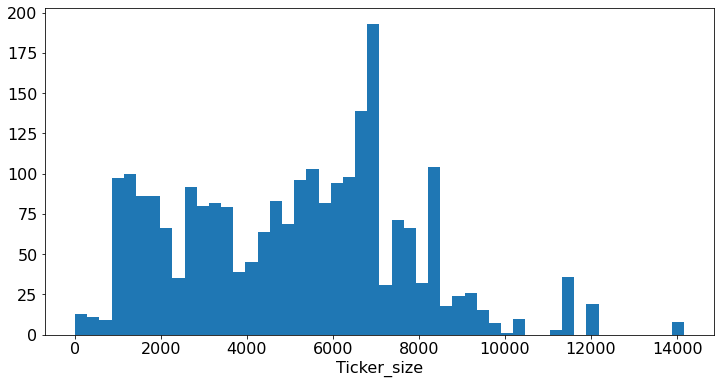

In [12]:

plt.hist(wiki_prices.groupby(['ticker']).size(),  bins=50)  
plt.xlabel('Ticker_size');

Few individual tickets data -> we suppose tickets behave the same because we could not meake individual analysis. Just separate in different segments.  
 


Use variable adj to simplify. Data Provider computes this figures to take into account splits, dividends and other corporte operations. This computation is perform from a single day point of view, so it is constantly updated


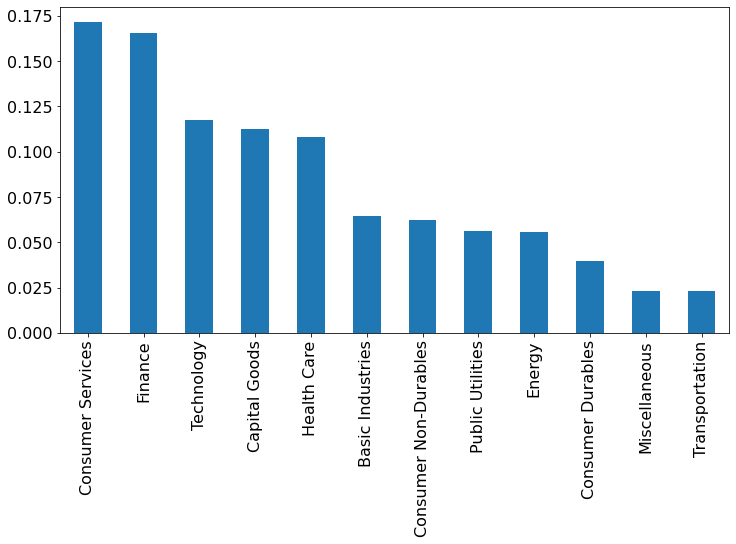

In [13]:
wiki_prices["sector"].value_counts(normalize=True).plot.bar()
plt.show()

# Data Preparation

## Targets

Targets is the objective variable to forecast/predict. They are computed as a **forward** price difference (return). There are many suitable ways to compute this differens:
* raw differences: p[t+tau] -p[t]
* raw-returns (pct_change): (p[t+tau] - p[t]) /p[t+tau]
* log-returns

Target horizon can be determined as a function of trading strategy (how many times a year do you want to rebalance your portfolio -the more frequent, the more brokerage cost-?, what kind of variables are you going to use?

In [14]:
raw_diffs = (wiki_prices
          .groupby('ticker')['adj_close']
          .diff(-tau))

In [15]:
raw_diffs_ex = wiki_prices.loc[ticker, 'adj_close'].iloc[0] - wiki_prices.loc[ticker, 'adj_close'].iloc[tau]
raw_diffs_ex

0.2291666666666663

In [16]:
raw_diffs.loc[ticker].iloc[0]

0.2291666666666663

In [17]:
assert np.isclose(raw_diffs_ex, raw_diffs.loc[ticker].iloc[0])

## Simple features + target

In [18]:
####3CONVERTIR A FUNCIONES
## fixing target what happen in 5 days forward
wiki_prices["lag_adj_close"]=wiki_prices.groupby("ticker")["adj_close"].shift(-tau)
wiki_prices["target"]=np.log(wiki_prices["lag_adj_close"]) - np.log(wiki_prices["adj_close"])

#5d
wiki_prices["lag_adj_close"]=wiki_prices.groupby("ticker")["adj_close"].shift(tau)
wiki_prices["x_returns5d"]=np.log(wiki_prices["adj_close"]) - np.log(wiki_prices["lag_adj_close"])
wiki_prices["x_diff5d"]=wiki_prices.groupby("ticker")["adj_close"].diff(tau)

wiki_prices["diff_target"]=wiki_prices.groupby("ticker")["x_diff5d"].shift(-tau)


#1d  just for visualization!!!!!!, obviously is not possible to train a model with that
wiki_prices["lag_adj_close"]=wiki_prices.groupby("ticker")["adj_close"].shift(1)
wiki_prices["x_returns1d"]=np.log(wiki_prices["adj_close"]) - np.log(wiki_prices["lag_adj_close"])

#1y  252 (just days with trading)
wiki_prices["lag_adj_close"]=wiki_prices.groupby("ticker")["adj_close"].shift(252) 
wiki_prices["x_returns1y"]=np.log(wiki_prices["adj_close"]) - np.log(wiki_prices["lag_adj_close"])
wiki_prices["x_diff1y"]=wiki_prices.groupby("ticker")["adj_close"].diff(252)

wiki_prices.drop(["lag_adj_close"], axis=1, inplace=True)

##  OTHER FEATURES

In [19]:
copy=wiki_prices.copy()

In [20]:
##Sector de_mean
wiki_prices["x_returns_1y_sdmean"]= wiki_prices.groupby( ["sector"])["x_returns1y"].apply(lambda x: (x-x.mean()))
# yearly rank ### arreglar


# yearly z_score
wiki_prices["x_returns_1y_zscr"] = (wiki_prices
            .groupby('date')['adj_close']
            .transform(lambda grp: (grp - grp.rolling(20).mean())/ grp.rolling(20).std() )
              )
#time smooth
def smooth(data, window:int):
    return data.rolling(window).mean()
wiki_prices["x_returns_1y_tsmooth"]= wiki_prices.groupby(level="ticker")["x_returns1y"].apply(lambda x:  smooth(x, window=2))

wiki_prices=wiki_prices.fillna(0)
wiki_prices["x_returns_1y_rnk"]= wiki_prices.groupby(level="date")["x_returns1y"].rank().astype(int)

In [21]:
feat_close_vs_open = wiki_prices['adj_open']-wiki_prices['adj_close']
feat_close_vs_open.name = 'x_close_vs_open'
##????????????????

In [22]:
wiki_prices.head(2)

open    high     low   close          volume  \
ticker date                                                         
A      1999-11-18 45.5000 50.0000 40.0000 44.0000 44,739,900.0000   
       1999-11-19 42.9400 43.0000 39.8100 40.3800 10,897,100.0000   

                   ex-dividend  split_ratio  adj_open  adj_high  adj_low  \
ticker date                                                                
A      1999-11-18       0.0000       1.0000   31.0420   34.1120  27.2896   
       1999-11-19       0.0000       1.0000   29.2954   29.3363  27.1600   

                   adj_close      adj_volume         sector  target  \
ticker date                                                           
A      1999-11-18    30.0186 44,739,900.0000  Capital Goods -0.0660   
       1999-11-19    27.5489 10,897,100.0000  Capital Goods  0.0424   

                   x_returns5d  x_diff5d  diff_target  x_returns1d  \
ticker date                                                          
A      1999-11-18       0.0000    0.0000      -1.9171       0.0000   
       1999-11-19       0.0000    0.0000       1.1939      -0.0859   

                   x_returns1y  x_diff1y  x_returns_1y_sdmean  \
ticker date                                                     
A      1999-11-18       0.0000    0.0000               0.0000   
       1999-11-19       0.0000    0.0000               0.0000   

                   x_returns_1y_zscr  x_returns_1y_tsmooth  x_returns_1y_rnk  
ticker date                                                                   
A      1999-11-18             0.0000                0.0000               720  
       1999-11-19             0.0000                0.0000               728

max(b-c-a-d)

In [23]:
close_open=wiki_prices["close"]-wiki_prices["open"]

In [24]:
open_high=wiki_prices["high"]-wiki_prices["open"] ###posit siempre

In [25]:
low_close=wiki_prices["close"]-wiki_prices["low"] ###poseit siempre

In [26]:
###quiero diferencia maxima de close y open y minima de high y los , tendre que maximizar el valor absoluto de: 
##close - open - (diff_max) - (diff_min)


wiki_prices["day_abs_change"]=np.abs(close_open)-open_high-low_close

In [27]:
np.corrcoef(wiki_prices["day_abs_change"], np.abs(wiki_prices["target"]))

array([[1.        , 0.00158945],
       [0.00158945, 1.        ]])

## filtering

In [28]:
### num tickets
avol = (
    wiki_prices
    .groupby('ticker')['adj_volume']
    .transform(lambda grp: grp.rolling(30).mean())
)
 

Full ticker population is very large, however some tickers may be quite illiquid (hard to trade at any time, due to offer/demand shortages). To overcome this, we can focus on highly trade tickers, therefore, to get a proxy of highly liquid stocks, a rolling average of volume can be obtained and then filter the stock population. This computation must be carried out daily

Only rolling volume computation is given as an example :)

In [29]:
### checking
avol.loc[ticker].tail()
avol_ex = (wiki_prices
 .loc[ticker, 'adj_volume']
 .iloc[-30:]  # try to never subset twice
 .mean()
)
avol_ex
avol.loc[ticker].iloc[-1]
assert np.isclose(avol.loc[ticker].iloc[-1], avol_ex)

In [30]:
## Tacking the top 500 each day:

In [31]:
wiki_prices["adj_volume_rm"]=wiki_prices.groupby('ticker')['adj_volume'].transform(lambda grp: grp.rolling(30).mean())
wiki_prices=wiki_prices.groupby('date').apply(lambda grp: grp.nlargest(500, 'adj_volume_rm'))
wiki_prices  = wiki_prices.droplevel(0)
#np.unique(wiki_prices.ticker)

In [32]:
##date filtering -> test creation (before filtering tickets)
test=wiki_prices.reset_index(["ticker", "date"])
test=test.pipe(dataprep.pl_filter, column="date", start_dt='2018-01-01', end_dt='2018-06-30')
test=test.set_index(["ticker", "date"])
test.drop("x_returns1d", axis=1, inplace =True)
test.to_pickle(path + "data/processed/test.pkl")


In [33]:
##date filtering 
wiki_prices=wiki_prices.reset_index(["ticker", "date"])
wiki_prices=wiki_prices.pipe(dataprep.pl_filter, column="date", start_dt=start_dt, end_dt=end_dt)
wiki_prices=wiki_prices.set_index(["ticker", "date"])
wiki_prices.to_pickle(path + "data/processed/wiki_prices.pkl")

In [34]:
len(pd.unique(wiki_prices.index.get_level_values(0) ))

958

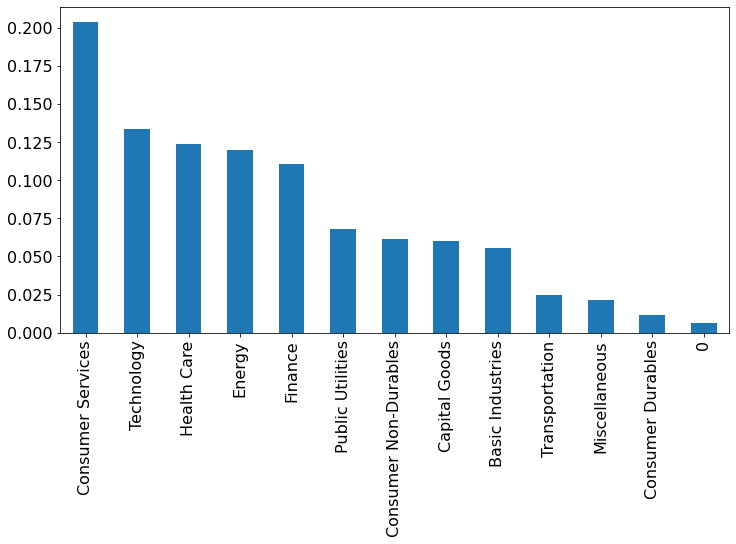

In [35]:
wiki_prices["sector"].value_counts(normalize=True).plot.bar()
plt.show()

<AxesSubplot:xlabel='date'>

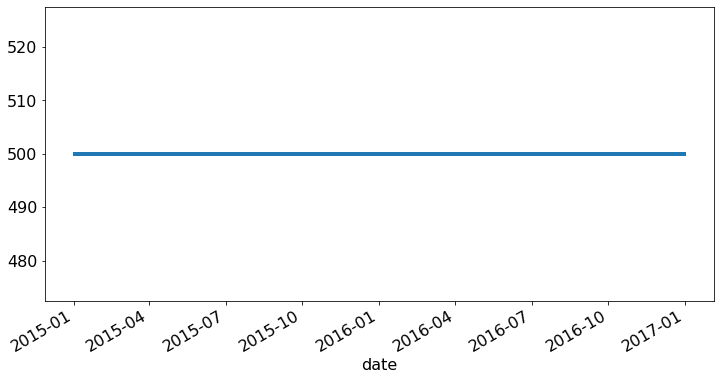

In [36]:
#numero de acciones 
n_tickers=wiki_prices.groupby("date").size()
n_tickers[n_tickers.index<"2017"].plot()

# Data Visualization

## S1

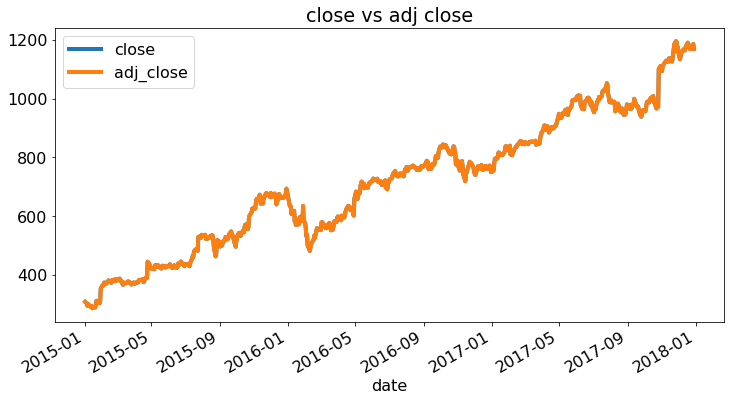

In [37]:
wiki_prices.loc[ticker, ['close', 'adj_close']].plot()
plt.title('close vs adj close')
plt.show()
### este grafico cuando no estaban filtrados los tickets cambiama un poco

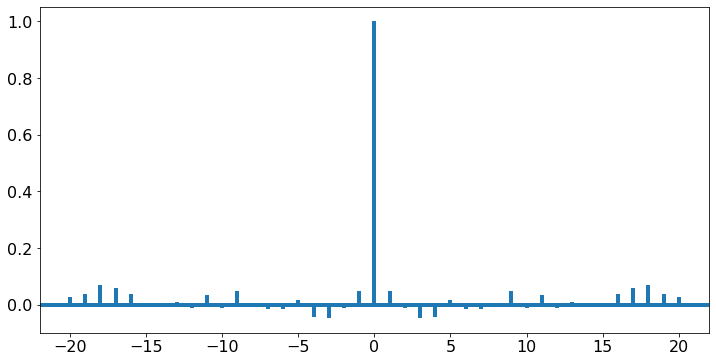

In [38]:
#correlacion entre las diferencias

lags, corr, lines, b = plt.xcorr(wiki_prices.loc[ticker][ 'adj_close'].diff().dropna(),wiki_prices.loc[ticker][ 'adj_close'].diff().dropna(), maxlags=20)
plt.show()


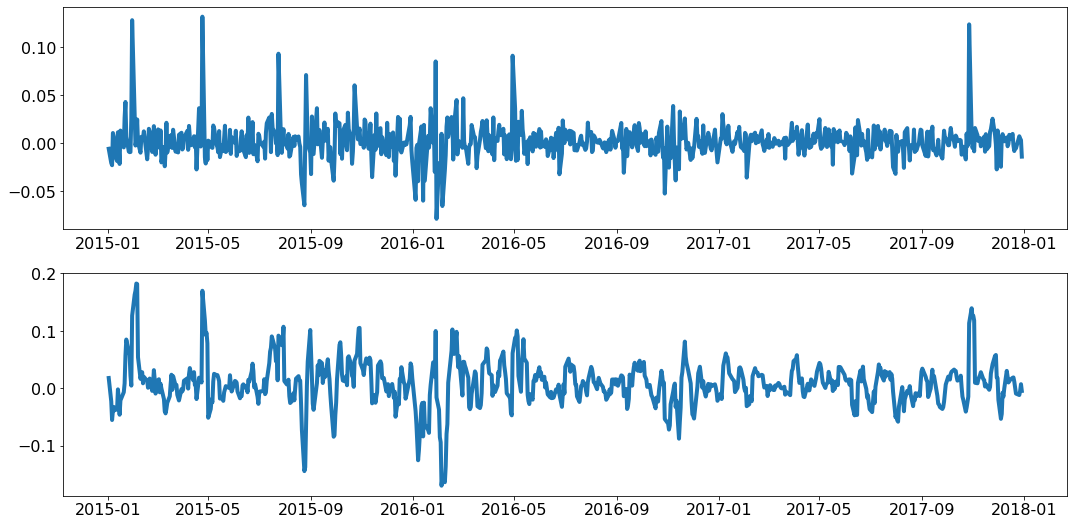

In [39]:
#plot de los retornos 

fig, axs = plt.subplots(2)
fig.set_size_inches(18, 9)
 

axs[0].plot(wiki_prices.loc[ticker]["x_returns1d"])
axs[1].plot(wiki_prices.loc[ticker]["x_returns5d"])
 

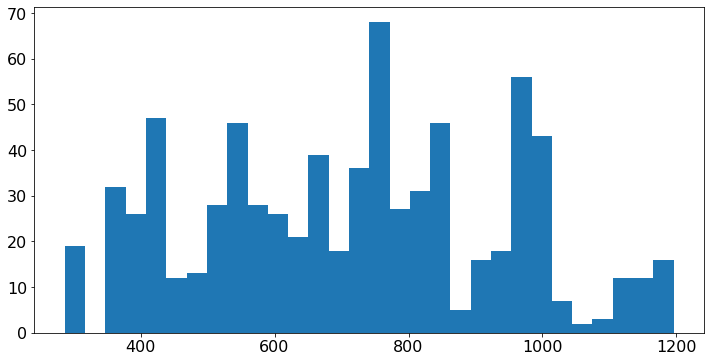

In [40]:
#histrograma variable 
fig.set_size_inches(10, 10)

plt.hist( wiki_prices.loc[ticker].adj_close, bins =30)
plt.show()

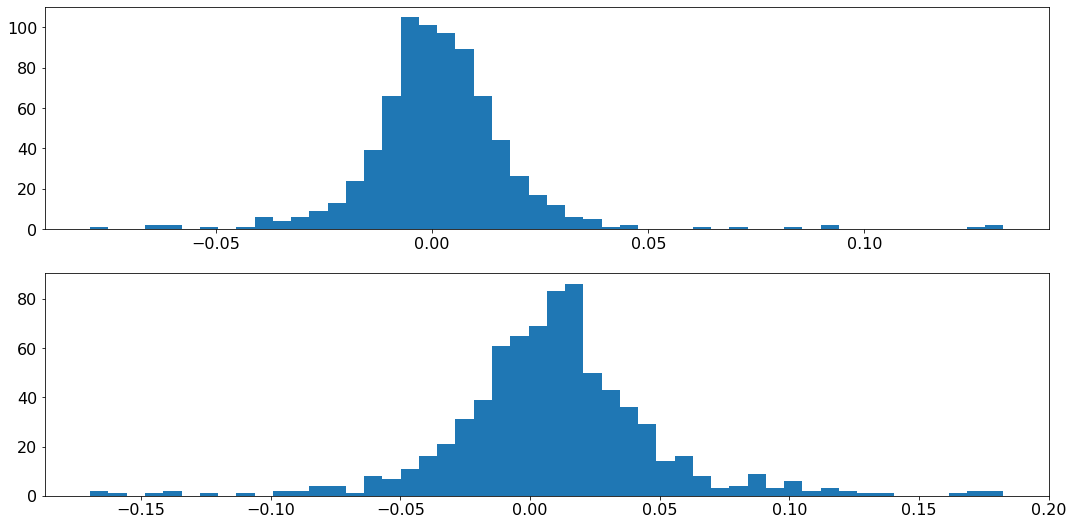

In [41]:
#histograma retornos 

fig, axs = plt.subplots(2)
fig.set_size_inches(18, 9) 

axs[0].hist(  wiki_prices.loc[ticker].x_returns1d, bins=50)
axs[1].hist(  wiki_prices.loc[ticker].x_returns5d, bins=50)
  
plt.show()

## Stationarity

ADFULLER

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [42]:


adfuller(wiki_prices.loc[ticker]["adj_close"])

#p value 0.90 -> no podemos rechazar la hipótesis nula -> la serie NO es estacionaria 

(-0.40975163130786196,
 0.9084578279399813,
 0,
 752,
 {'1%': -3.439075747702915,
  '5%': -2.8653910653234655,
  '10%': -2.568820711931304},
 5676.7869121505)

In [43]:
#p value <0.05 ->   podemos rechazar la hipótesis nula -> la serie ES estacionaria 

display(adfuller(wiki_prices.loc[ticker]["x_returns5d"]))

(-4.935361624322823,
 2.974877535044535e-05,
 20,
 732,
 {'1%': -3.439314999916068,
  '5%': -2.8654965012008677,
  '10%': -2.5688768817372867},
 -3731.7671087032677)

In [44]:
#p value <0.05 ->   podemos rechazar la hipótesis nula -> la serie ES estacionaria 

display(adfuller(wiki_prices.loc[ticker]["x_returns1d"]))

(-25.99485758460855,
 0.0,
 0,
 752,
 {'1%': -3.439075747702915,
  '5%': -2.8653910653234655,
  '10%': -2.568820711931304},
 -3876.9539734156833)

## Descriptive Statistics

In [45]:
wiki_prices.loc[ticker]["x_returns5d"].describe()

count   753.0000
mean      0.0089
std       0.0395
min      -0.1696
25%      -0.0111
50%       0.0086
75%       0.0264
max       0.1825
Name: x_returns5d, dtype: float64

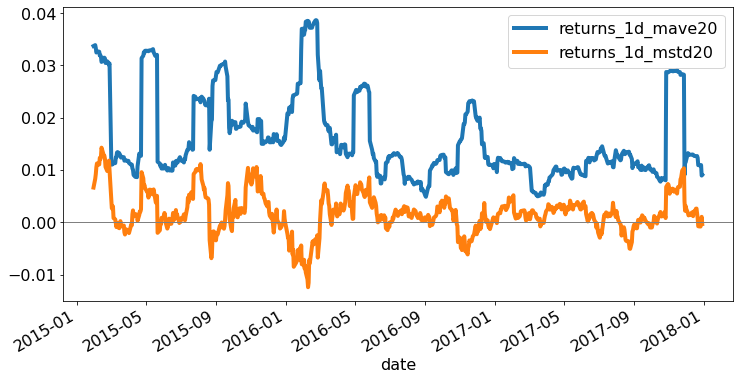

In [46]:
singl_stock_roll20 = wiki_prices.loc[ticker].rolling(20)

singl_stock = wiki_prices.loc[ticker].assign(
    returns_1d_mave20=singl_stock_roll20["x_returns1d"].std(),
    returns_1d_mstd20=singl_stock_roll20["x_returns1d"].mean())

singl_stock.plot(y=["returns_1d_mave20","returns_1d_mstd20"])
plt.axhline(y=0,linewidth=1, color ="grey")

#la serie no es normal media no es 0, :-> thats mean there is some tendency of going up 

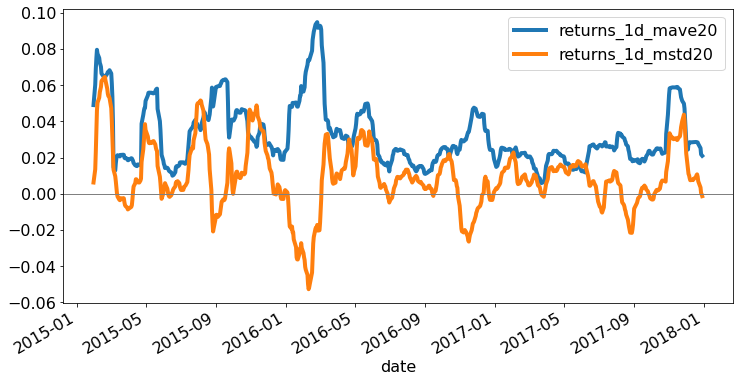

In [47]:
singl_stock_roll20 = wiki_prices.loc[ticker].rolling(20)

singl_stock = wiki_prices.loc[ticker].assign(
    returns_1d_mave20=singl_stock_roll20["x_returns5d"].std(),
    returns_1d_mstd20=singl_stock_roll20["x_returns5d"].mean())

singl_stock.plot(y=["returns_1d_mave20","returns_1d_mstd20"])
plt.axhline(y=0,linewidth=1, color ="grey")

#la serie no es normal media no es 0, : 

## ACF and PACF 

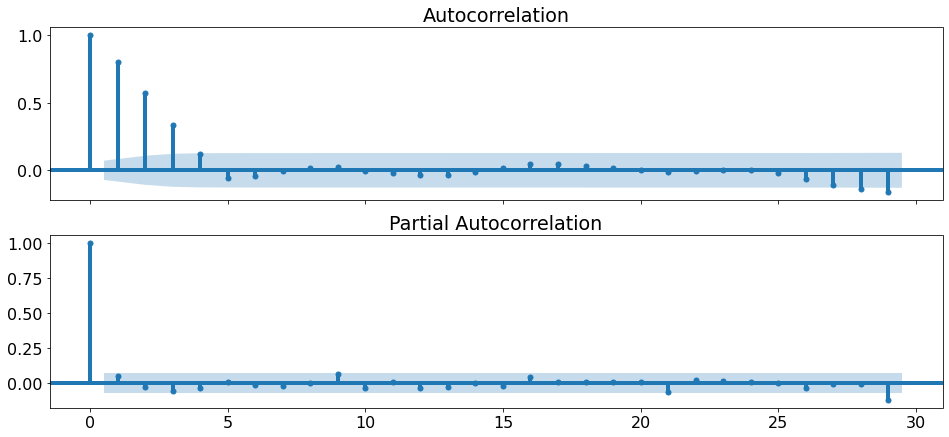

In [48]:
fif, axs=plt.subplots(2,1, figsize=(16,7), sharex=True)

ax=axs[0]
plot_acf(singl_stock["x_returns5d"], ax=ax)
ax=axs[1]
plot_pacf(singl_stock["x_returns1d"], ax=ax)

plt.show()

## Benchmark model 

In [49]:
wiki_prices[["x_returns5d","target"]].corr(method="spearman")

,x_returns5d,target
x_returns5d,1.0000,-0.0262
target,-0.0262,1.0000


In [50]:
mean_squared_error(y_true=wiki_prices["target"], y_pred=wiki_prices["x_returns5d"])

0.007926234312779746

In [51]:
accuracy_score(y_true=np.sign(wiki_prices["target"]), y_pred=np.sign(wiki_prices["x_returns5d"]))

0.4874936340873403

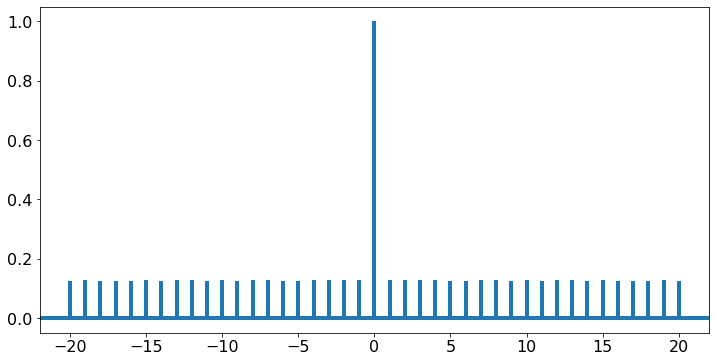

In [52]:
lags, corr, lines, b = plt.xcorr(wiki_prices["x_returns5d"] ,wiki_prices["x_returns5d"] , maxlags=20)

## S2

In [53]:
SMPL_DATE="2015-01-02"
wiki_prices=wiki_prices.reset_index([ "date"])

select_cols= ["adj_close","target", "x_returns1y","x_returns_1y_rnk","x_returns_1y_sdmean","x_returns_1y_zscr","x_returns_1y_tsmooth"]
smpl_day_1y_rets=wiki_prices[wiki_prices["date"]==SMPL_DATE][select_cols]


In [54]:
#smlp_day_1y_rets=wiki_prices.xs(level="date", key=SMPL_DATE)[select_cols]

smpl_day_1y_rets=smpl_day_1y_rets.reset_index()

<AxesSubplot:>

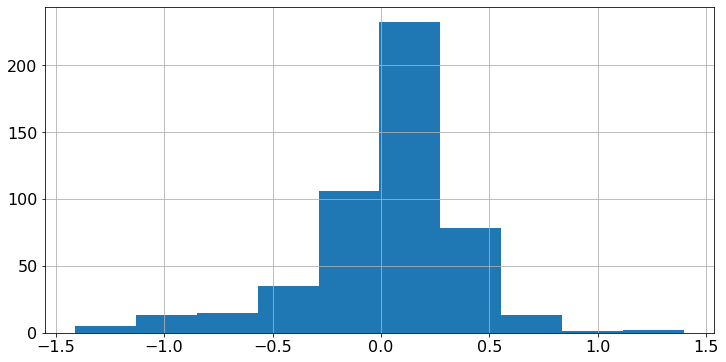

In [55]:
smpl_day_1y_rets["x_returns1y"].hist()

In [56]:
pd.concat([smpl_day_1y_rets.head(),smpl_day_1y_rets.tail()])

,ticker,adj_close,target,x_returns1y,x_returns_1y_rnk,x_returns_1y_sdmean,x_returns_1y_zscr,x_returns_1y_tsmooth
0,BAC,17.2216,-0.0528,0.1132,1404,0.0199,-0.4485,0.1297
1,AAPL,103.8640,0.0242,0.3455,2129,0.2686,0.0000,0.3432
2,GE,22.8851,-0.0420,-0.0586,680,-0.0963,-0.2011,-0.0640
3,KMI,38.4824,-0.0236,0.2235,1822,0.1448,-0.0929,0.2164
4,INTC,33.0347,0.0109,0.3750,2179,0.2981,-0.0703,0.3709
495,AON,91.0358,0.0048,0.1467,1539,0.0534,0.4481,0.1402
496,MTZ,21.7000,-0.0496,-0.4021,192,-0.4790,-0.6486,-0.3858
497,LB,76.5812,-0.0078,0.3746,2178,0.2975,0.9948,0.3754
498,GRMN,45.3789,-0.0219,0.1914,1710,0.1050,-0.2666,0.1801
499,AEE,41.2776,-0.0218,0.2976,2036,0.2189,-0.1574,0.2904


In [57]:
smpl_day_1y_rets[smpl_day_1y_rets.ticker=="CLF"]

,ticker,adj_close,target,x_returns1y,x_returns_1y_rnk,x_returns_1y_sdmean,x_returns_1y_zscr,x_returns_1y_tsmooth
57,CLF,7.0300,0.0169,-1.2629,15,-1.3398,-0.7897,-1.2624


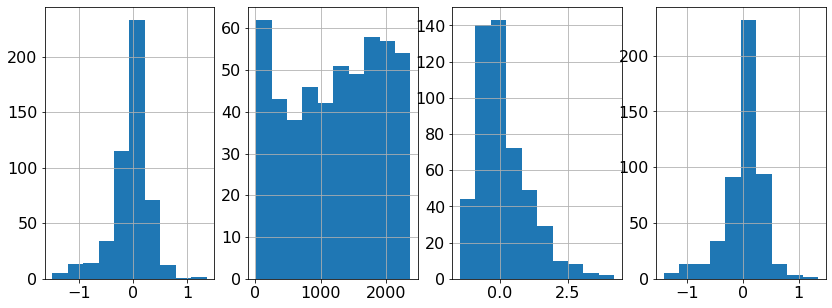

In [58]:
fig, axs =plt.subplots(1,4, figsize=(14,5))

ax=axs[0]
smpl_day_1y_rets["x_returns_1y_sdmean"].hist(ax=ax)

ax=axs[1]
smpl_day_1y_rets["x_returns_1y_rnk"].hist(ax=ax)

ax=axs[2]
smpl_day_1y_rets["x_returns_1y_zscr"].hist(ax=ax)

ax=axs[3]
smpl_day_1y_rets["x_returns_1y_tsmooth"].hist(ax=ax)

plt.show()

## Correlation Analysis

<AxesSubplot:xlabel='x_returns1y', ylabel='target'>

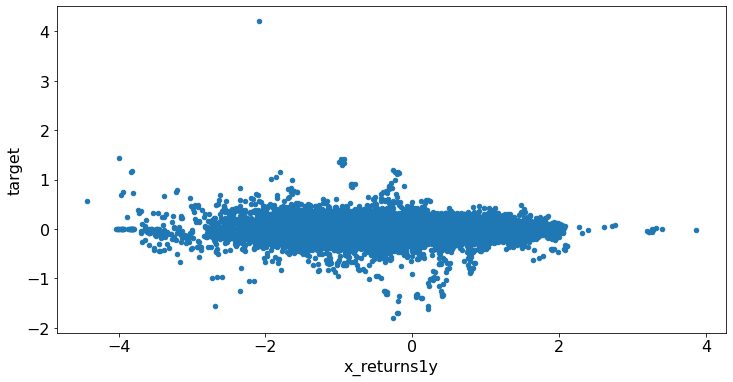

In [59]:
wiki_prices.plot(kind='scatter', x='x_returns1y', y='target')

In [60]:
wiki_prices[["x_returns1y","target"]].corr(method="spearman") 

,x_returns1y,target
x_returns1y,1.0000,-0.0019
target,-0.0019,1.0000


In [61]:
corr_over_time=wiki_prices.groupby(["date"])[["x_returns1y","target"]].corr(method="spearman").reset_index()

In [62]:
corr_over_time=corr_over_time[corr_over_time.level_1=="target"][["date" ,"level_1", "x_returns1y"]]

In [63]:
corr_over_time

,date,level_1,x_returns1y
1,2015-01-02,target,0.4001
3,2015-01-05,target,0.3544
5,2015-01-06,target,0.2831
7,2015-01-07,target,0.1412
9,2015-01-08,target,0.3144
...,...,...,...
1501,2017-12-22,target,-0.1051
1503,2017-12-26,target,0.0312
1505,2017-12-27,target,-0.0472
1507,2017-12-28,target,0.0756


In [64]:
corr_over_time["x_returns1y"].median()

0.024366247897681603

<AxesSubplot:xlabel='date'>

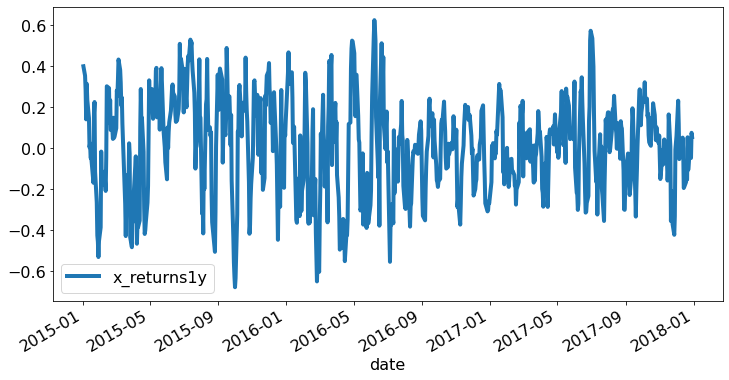

In [65]:
corr_over_time.plot(kind='line', x='date', y='x_returns1y')
#plt.axline(0,corr_over_time["x_returns1y"].median(), linewith=1.5, color="black")


#### no me deja pintar la mediana

In [66]:
corr_over_ticket=wiki_prices.groupby( level="ticker" )[["x_returns1y","target"]].corr(method="spearman").reset_index()

In [67]:
corr_over_ticket=corr_over_ticket[corr_over_ticket.level_1=="x_returns1y"][["ticker" ,"level_1", "target"]].dropna()

<AxesSubplot:xlabel='ticker'>

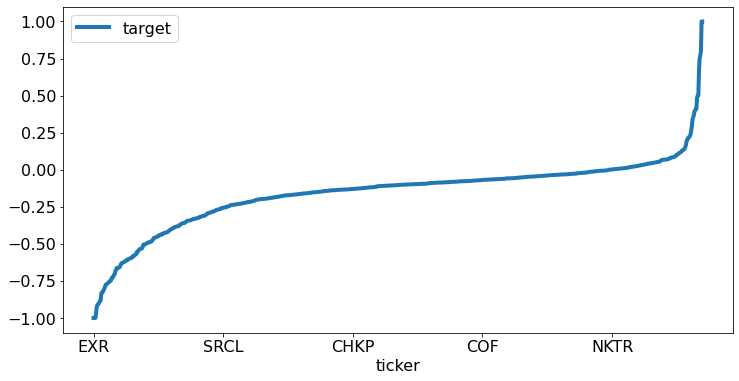

In [68]:
corr_over_ticket.sort_values("target").plot(x="ticker", y="target")


<AxesSubplot:xlabel='ticker'>

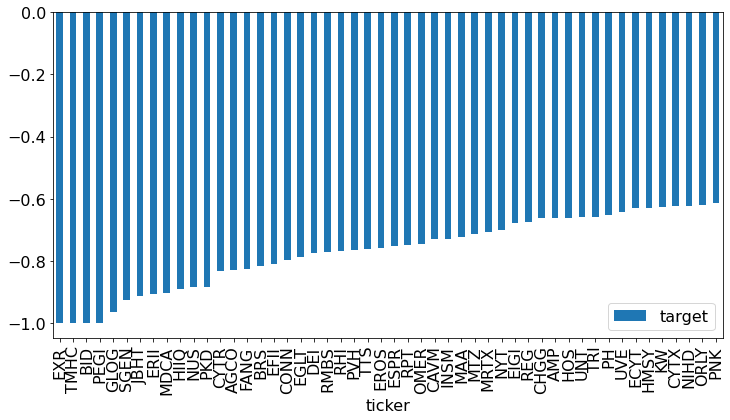

In [69]:
corr_over_ticket.sort_values("target").iloc[0:50].plot(kind="bar",x="ticker", y="target")


<AxesSubplot:xlabel='ticker'>

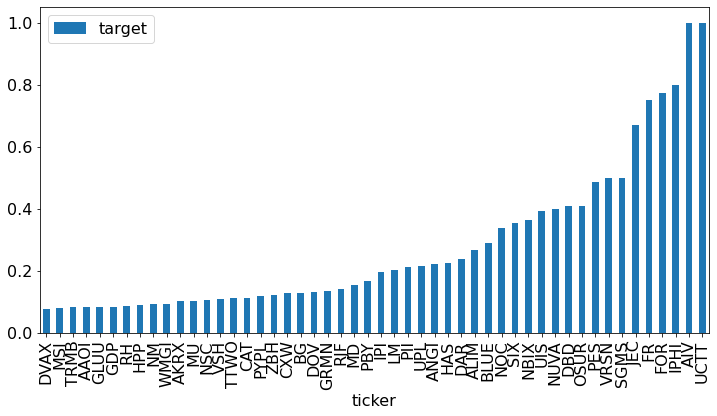

In [70]:
corr_over_ticket.sort_values("target").iloc[-50:].plot(kind="bar",x="ticker", y="target")
